In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_docs as tfdocs
tf.keras.backend.clear_session()
print('Tensorflow version: %s' % str(tf.__version__))

print('Setup tensor board extension')
%load_ext tensorboard
assert tf._major_api_version >= 2, "This notebook requires TensorFlow 2.0 or above."

import sys
import os
if sys.platform.startswith('darwin'):
    print('Enable multiple instances of OpenMP on macOS')
    os.environ['KMP_DUPLICATE_LIB_OK']='True'
print()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
print('Prepared data visualization')
print()

import numpy as np
import pandas as pd
import pathlib
print('Prepared data manipulation, numpy version: ', str(np.__version__))

Tensorflow version: 2.3.1
Setup tensor board extension
Enable multiple instances of OpenMP on macOS

Prepared data visualization

Prepared data manipulation, numpy version:  1.18.5


In [2]:
print('Process images')
img_root = pathlib.Path(tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    fname='flower_photos', untar=True))
print('Load flower images to ', img_root)

Process images
Load flower images to  /Users/hzhou/.keras/datasets/flower_photos


In [3]:
print('Setup list of all flower images')
images = [str(path) for path in list(img_root.glob('*/*'))]
print('Count of images: {}'.format(len(images)))
print()

print('Shuffle images')
import random
random.shuffle(images)

Setup list of all flower images
Count of images: 3670

Shuffle images


In [4]:
print('Load license info of images')
image_licenses = {}
with open(img_root/'LICENSE.txt', encoding='utf-8') as f:
    for line in f.readlines():
        parts = line.split(' CC-BY ')
        if len(parts) == 2:
            image_licenses[parts[0]] = ' - '.join(parts[1].split(' - ')[:-1])
print('Count of license info: {}'.format(len(image_licenses)))

Load license info of images
Count of license info: 3670


Photo by Parvin


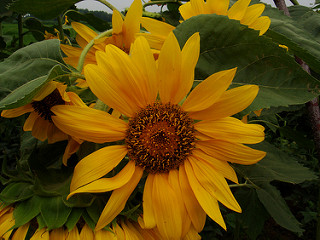

Photo by Audrey


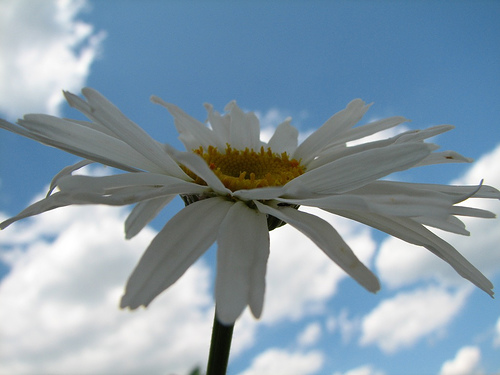

Photo by jenny downing


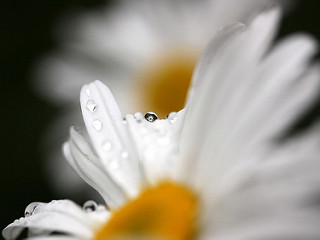

In [5]:
for n in range(3):
    image_path = random.choice(images)
    image_ref = str(pathlib.Path(image_path).relative_to(img_root))
    if image_ref in image_licenses:
        print('Photo ' + image_licenses[image_ref])
    else:
        print('No license info for ' + image_path)
    IPython.display.display(IPython.display.Image(image_path))

In [6]:
print('Prepare image labels')
flower_types = sorted(item.name for item in img_root.glob('*/') if item.is_dir())
flower_type_indexes = dict((name, index) for index, name in enumerate(flower_types))
print('Flower type indexes: ', end='')
print(flower_type_indexes)
image_labels = [flower_type_indexes[pathlib.Path(path).parent.name] for path in images]

Prepare image labels
Flower type indexes: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [7]:
print('Prepare image dataset')

# function to process image into fixed size data
def preprocess_image(image, size=[192,192]):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image /= 255.0  # normalize to [0,1] range
    return image

# function to load and pre-process image file
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

# function to parse path into data
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

# function to prepare image dataset
def generate_image_dataset(image_paths, image_labels, repeat_cnt = None, batch_size = 32):
    image_count = len(image_paths)
    if image_count == 0:
        print('No image input')
        return tf.data.Dataset.range(0)
    if len(image_labels) != image_count:
        print('Sizes of images and labels are not match')
        return tf.data.Dataset.range(0)
    image_path_ds = tf.data.Dataset.from_tensor_slices((images, image_labels))
    image_ds = image_path_ds.map(load_and_preprocess_from_path_label)
    image_ds = image_ds.shuffle(buffer_size=image_count).repeat(repeat_cnt).batch(batch_size)
    return image_ds

image_ds = generate_image_dataset(images, image_labels)
image_ds

Prepare image dataset


<BatchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [8]:
print('Load text data')
txt_remote_path = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad'
txt_names = ['cowper.txt', 'derby.txt', 'butler.txt']
txt_paths = []
for name in txt_names:
    txt_paths.append(tf.keras.utils.get_file(name, origin=txt_remote_path+'/'+name))
txt_root = pathlib.Path(txt_paths[0]).parent
print('Text files saved to '+str(txt_root))

Load text data
Text files saved to /Users/hzhou/.keras/datasets


In [9]:
print('Setup dataset')
txt_files = []
for i, txt_path in enumerate(txt_paths):
    lines = tf.data.TextLineDataset(txt_path)
    labeled = lines.map(lambda l: (l, tf.cast(i,tf.int64)))
    txt_files.append(labeled)
txt_ds = txt_files[0]
for file in txt_files[1:]:
    txt_ds = txt_ds.concatenate(file)
txt_ds = txt_ds.shuffle(50000, reshuffle_each_iteration=False)
print('The first 3 samples are')
for ex in txt_ds.take(3):
    print(ex)

Setup dataset
The first 3 samples are
(<tf.Tensor: shape=(), dtype=string, numpy=b"Who sent from Heav'n a show'r of blood-stain'd rain.">, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b"Rain'd under them from neck and chest profuse,">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b"And ev'ry crag, and ev'ry jutting peak">, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [10]:
print('Tokenizer text')
tokenizer = tfds.features.text.Tokenizer()
vocabulary = set()
for text_tensor, _ in txt_ds:
    tokens = tokenizer.tokenize(text_tensor.numpy())
    vocabulary.update(tokens)

print('Size of total vocabulary is {}'.format(len(vocabulary)))

Tokenizer text
Size of total vocabulary is 17178


In [11]:
print('Vectorize text')
encoder = tfds.features.text.TokenTextEncoder(vocabulary) # prepare encoder
def encode(text_tensor, label):
    encoded_text = encoder.encode(text_tensor.numpy())
    return encoded_text, label
def encode_txt_sample(text_tensor, label): # prepare function encode text
    encoded, label = tf.py_function(encode, inp=[text_tensor, label], Tout=(tf.int64, tf.int64))
    encoded.set_shape([None])
    label.set_shape([])
    return encoded, label
txt_vec_ds = txt_ds.map(encode_txt_sample)
print('Now the first 3 samples become')
for ex in txt_vec_ds.take(3):
    print(ex)

Vectorize text
Now the first 3 samples become
(<tf.Tensor: shape=(13,), dtype=int64, numpy=
array([ 1030, 10440,  8865,  8777, 16221, 16798, 11899, 15174,  8125,
        5991, 16653,  2123, 10158])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(9,), dtype=int64, numpy=array([13136,  2123,  9510,  5163,  8865,    13,  7707, 14486,  1681])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(9,), dtype=int64, numpy=array([13619, 15896,  6169,  4707,  7707, 15896,  6169,  8648,  9012])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [12]:
print('Split into training and text datasets')
txt_train_data = txt_vec_ds.skip(5000).shuffle(50000).padded_batch(64,padded_shapes=([None],[]))
txt_test_data = txt_vec_ds.take(5000).padded_batch(64,padded_shapes=([None],[]))

Split into training and text datasets


In [13]:
print('Setup txt model')
txt_model_logpath = 'logs/fit/txt_lstm'
os.system('rm -rf ' + txt_model_logpath)
txt_tb_callback = tf.keras.callbacks.TensorBoard(log_dir=txt_model_logpath)
txt_model = tf.keras.Sequential()
txt_model.add(tf.keras.layers.Embedding(len(vocabulary)+1, 64)) # input layer to parse text list into a sparse vector with fixed size
txt_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))) # use LSTM layer to reveal text context info
for units in [64,64]:
    txt_model.add(tf.keras.layers.Dense(units, activation='relu')) # normal internal layers
txt_model.add(tf.keras.layers.Dense(3, activation='softmax')) # output layer (3 labels)
txt_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print('Train txt model')
txt_model.fit(txt_train_data, epochs=3, validation_data=txt_test_data, callbacks=[txt_tb_callback])

print('Evaluate txt model')
txt_eval_loss, txt_eval_acc = txt_model.evaluate(txt_test_data)
print('Eval loss: {}, Eval accuracy: {}'.format(txt_eval_loss, txt_eval_acc))

Setup txt model
Train txt model
Epoch 1/3
      1/Unknown - 0s 78us/step - loss: 1.0989 - accuracy: 0.3281WARNING:tensorflow:From /Users/hzhou/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
      2/Unknown - 0s 77ms/step - loss: 1.0974 - accuracy: 0.3438WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0313s vs `on_train_batch_end` time: 0.1228s). Check your callbacks.
697/697 [==============================] - 23s 33ms/step - loss: 0.5176 - accuracy: 0.7454 - val_loss: 0.3770 - val_accuracy: 0.8318
Epoch 2/3
697/697 [==============================] - 23s 32ms/step - loss: 0.2958 - accuracy: 0.8691 - val_loss: 0.3659 - val_accuracy: 0.8392
Epoch 3/3
697/697 [==============================] - 23s 33ms/step - loss: 0.2208 - accur

Save model structure to image


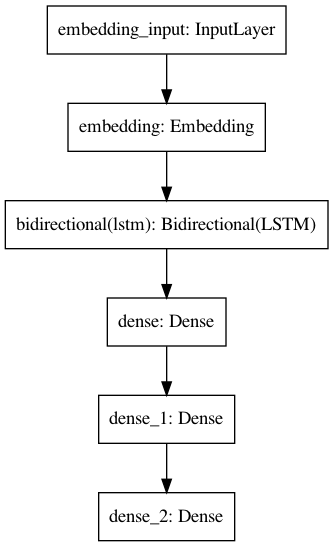

In [14]:
print('Save model structure to image')
tf.keras.utils.plot_model(txt_model, to_file='txt_model.png')

In [15]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 9650), started 1 day, 3:02:35 ago. (Use '!kill 9650' to kill it.)